# Agitation prediction: Prediction models

**Author:** Eva Rombouts  
**Date:** 2024  
**Version:**  

### Description
In this notebook, we create and test a model to detect agitation in nursing home reports using the RoBERTa transformer model. We used a dataset generated by ChatGPT for training and validation. Although the model performed exceptionally well on both training and validation data, it struggled with new, self-written reports. This is likely due to overfitting on the consistent style of the generated data. This notebook walks through the process of loading data, training the model, evaluating its performance, and making predictions.

In [1]:
# Install necessary libraries
%%capture
!pip install -U accelerate
!pip install -U transformers

In [2]:
# Import libraries and mount Google Drive
import os
from datetime import datetime
import pandas as pd
import torch
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, RobertaTokenizer, BertForSequenceClassification, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

# Mount Google Drive
drive.mount('/content/drive')

# Set base directories
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/GenCareAI'
SCRIPTS_PATH = os.path.join(BASE_PATH, 'scripts')
DATA_PATH = os.path.join(BASE_PATH, 'data')
MODEL_SAVE_PATH = os.path.join(BASE_PATH, 'models/RobertaClassification')

# Change to the scripts directory
os.chdir(SCRIPTS_PATH)

Mounted at /content/drive


In [17]:
# Load and preprocess datasets
# Load datasets from Google Drive
train_df = pd.read_csv(os.path.join(DATA_PATH, 'agitation_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'agitation_valid.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'agitation_test.csv'))

# Sample a subset for faster processing
train_df = train_df.sample(n=10000, random_state=6)
valid_df = valid_df.sample(n=2000, random_state=6)
test_df = test_df.sample(n=2000, random_state=6)

# Extract texts and labels
train_texts, train_labels = train_df['text'].tolist(), train_df['label'].astype(int).tolist()
valid_texts, valid_labels = valid_df['text'].tolist(), valid_df['label'].astype(int).tolist()
test_texts, test_labels = test_df['text'].tolist(), test_df['label'].astype(int).tolist()

In [18]:
# Initialize tokenizer and model (RoBERTa)
# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('pdelobelle/robbert-v2-dutch-base')

# Load the pre-trained model with a classification head
model = RobertaForSequenceClassification.from_pretrained('pdelobelle/robbert-v2-dutch-base', num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Define custom dataset class
class AgitationDataset(Dataset):
    def __init__(self, texts, labels):
        # Tokenize the texts
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels

    def __getitem__(self, idx):
        # Return a single tokenized item and its label
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        # Return the total number of items
        return len(self.labels)

# Create datasets for training and validation
train_dataset = AgitationDataset(train_texts, train_labels)
valid_dataset = AgitationDataset(valid_texts, valid_labels)

In [20]:
# Set training arguments and directories
# Set output and logging directories with timestamps
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = f'{BASE_PATH}/results/{timestamp}'
logging_dir = f'{BASE_PATH}/logs/{timestamp}'

# Create directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=output_dir,               # Directory where the output and checkpoints are saved
    num_train_epochs=3,                  # Total number of training epochs
    per_device_train_batch_size=16,      # Batch size per device during training
    per_device_eval_batch_size=64,       # Batch size per device during evaluation
    warmup_steps=500,                    # Number of warm-up steps
    weight_decay=0.01,                   # Weight decay rate
    logging_dir=logging_dir,             # Directory for logs
    logging_steps=100,                   # Log every n steps
    save_strategy="steps",               # Checkpoint saving strategy
    save_steps=1000,                     # Save a checkpoint every 1000 steps
    save_total_limit=2,                  # Maximum number of checkpoints to save
)

In [21]:
# Initialize Trainer and train the model
trainer = Trainer(
    model=model,                         # The instantiated Transformers model to be trained
    args=training_args,                  # Training arguments, defined above
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=valid_dataset           # Evaluation dataset
)

# Train the model
trainer.train()

Step,Training Loss
100,0.364900
200,0.052600
300,0.043800
400,0.061100
500,0.062300
600,0.053000
700,0.022700
800,0.027500
900,0.025700
1000,0.020000


TrainOutput(global_step=1875, training_loss=0.04290693114524086, metrics={'train_runtime': 280.8299, 'train_samples_per_second': 106.826, 'train_steps_per_second': 6.677, 'total_flos': 1449166359600000.0, 'train_loss': 0.04290693114524086, 'epoch': 3.0})

In [22]:
# Save the trained model
# Create the directory if it doesn't exist
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Save the trained model
model.save_pretrained(MODEL_SAVE_PATH)

# Confirm model save
print(f"Model saved at {MODEL_SAVE_PATH}")

Model saved at /content/drive/MyDrive/Colab Notebooks/GenCareAI/models/RobertaClassification


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1754
           1       1.00      0.99      0.99       246

    accuracy                           1.00      2000
   macro avg       1.00      0.99      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Accuracy Score:
0.998
AUC: 1.00


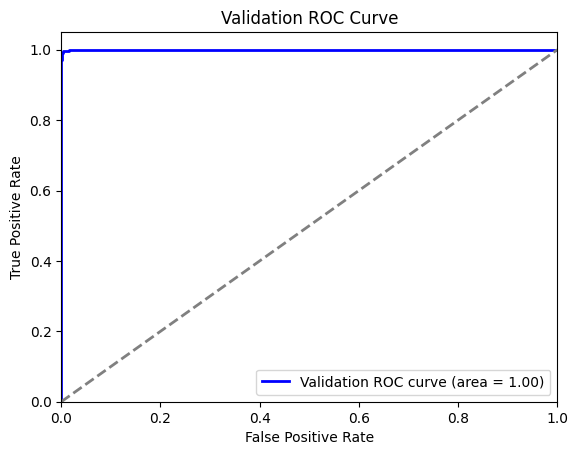

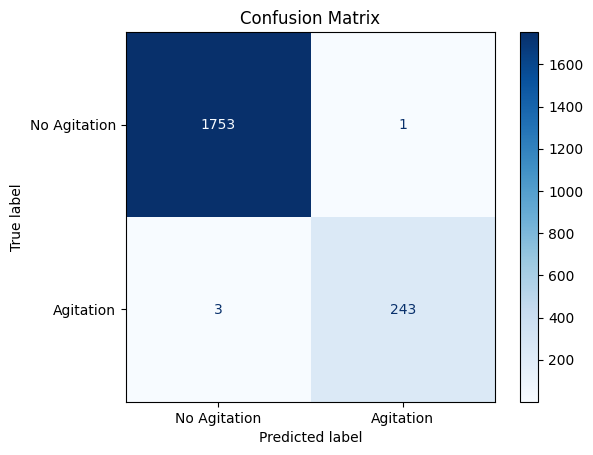

In [23]:
### Evaluate the model on the validation set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and probabilities for the validation set
valid_predictions = trainer.predict(valid_dataset)
valid_preds = valid_predictions.predictions.argmax(-1)
valid_probs = torch.nn.functional.softmax(torch.tensor(valid_predictions.predictions), dim=-1).numpy()[:, 1]

# Compute the usual metrics for binary classification
print("Classification Report:")
print(classification_report(valid_labels, valid_preds))

print("Accuracy Score:")
print(accuracy_score(valid_labels, valid_preds))

# Compute the AUC
valid_auc = roc_auc_score(valid_labels, valid_probs)
print(f"AUC: {valid_auc:.2f}")

# Plot the ROC curve
fpr_valid, tpr_valid, _ = roc_curve(valid_labels, valid_probs)

plt.figure()
plt.plot(fpr_valid, tpr_valid, color='blue', lw=2, label=f'Validation ROC curve (area = {valid_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Compute and display the confusion matrix
cm = confusion_matrix(valid_labels, valid_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Agitation', 'Agitation'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [26]:
type(test_dataset)

__main__.AgitationDataset

In [27]:
# Get predictions and probabilities
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

# Show some examples with their predictions and probabilities
for i in range(5):  # Show first 5 examples
    print(f"Text: {test_texts[i]}")
    print(f"Actual Label: {test_labels[i]}")
    print(f"Predicted Label: {preds[i]}")
    print(f"Probability: {probs[i]}")
    print("\n")

Text: Na het ongelukje met de kleding, is mw. geholpen met verschonen en het opfrissen van haarzelf.
Actual Label: 0
Predicted Label: 0
Probability: [9.9997854e-01 2.1491873e-05]


Text: Mw grijpt telkens naar de bloempot en probeert deze te verstoppen onder haar kussen. Vervangen door een nepplant als afleiding.
Actual Label: 1
Predicted Label: 1
Probability: [1.0501978e-04 9.9989498e-01]


Text: Bij mevrouw opgemerkt: ontvelling tussen tenen. Geen tekenen van infectie. Intensief advies gegeven over persoonlijke hygiëne en juiste schoeisel.
Actual Label: 0
Predicted Label: 0
Probability: [9.9997842e-01 2.1566524e-05]


Text: Bij de mobilisatieoefeningen was cliënt erg gemotiveerd en kon zelfs een paar extra stappen zetten met de rollator. Mooie vooruitgang!"
Actual Label: 0
Predicted Label: 0
Probability: [9.999733e-01 2.673943e-05]


Text: Dhr zat aan tafel en begon plotseling zijn koffie over zijn bord met brood te gieten. Toen hem werd gevraagd waarom hij dit deed, keek hij verward

In [29]:
# New nursing home report
new_report = ["Dhr liep geagiteerd over de afdeling. Ik probeerde hem te kalmeren, maar dat lukte niet. Heeft zijn zonodig medicatie gekregen."]
# new_report = ["Dhr zat aan tafel en begon plotseling zijn koffie over zijn bord met brood te gieten. Toen hem werd gevraagd waarom hij dit deed, keek hij verward en mompelde iets over een zwemmende vis. Dhr vriendelijk verzocht om te stoppen met morsen en rustig zijn ontbijt op te eten."]

# Preprocess the new report using the tokenizer
new_encoding = tokenizer(new_report, truncation=True, padding=True, max_length=512, return_tensors='pt')

# Move the new encoding to CUDA
new_encoding = {key: val.cuda() for key, val in new_encoding.items()}
model.cuda()

# Make prediction on the new report
with torch.no_grad():
    output = model(**new_encoding)
    prediction = output.logits.argmax(dim=1).cpu().numpy()
    probability = torch.nn.functional.softmax(output.logits, dim=-1).cpu().numpy()

# Print the prediction and probability
print(f"Report: {new_report[0]}")
print(f"Predicted Label: {'Agitation' if prediction[0] == 1 else 'No Agitation'}")
print(f"Probability of Agitation: {probability[0][1]:.2f}")

Report: Dhr zat aan tafel en begon plotseling zijn koffie over zijn bord met brood te gieten. Toen hem werd gevraagd waarom hij dit deed, keek hij verward en mompelde iets over een zwemmende vis. Dhr vriendelijk verzocht om te stoppen met morsen en rustig zijn ontbijt op te eten.
Predicted Label: Agitation
Probability of Agitation: 1.00
